In [1]:
import matplotlib
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import svd
from scipy.linalg import pinv
import seaborn as sns
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.ticker import MaxNLocator
os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/mouse protein')


In [2]:
data = np.genfromtxt('Data_Cortex_Nuclear.csv',delimiter=',',
                     skip_header=1,usecols=range(1,78),filling_values=0)
classes = np.genfromtxt('Data_Cortex_Nuclear.csv',delimiter=',',
                        skip_header=1,usecols=range(78,81),dtype=None)

data_pd = pd.read_csv("Data_Cortex_Nuclear.csv")

target_idx_A = np.where((classes[:,-1]=='S/C') & (classes[:,-2]=='Saline') & (classes[:,-3]=='Control'))[0]
target_idx_B = np.where((classes[:,-1]=='S/C') & (classes[:,-2]=='Saline') & (classes[:,-3]=='Ts65Dn'))[0]

labels = len(target_idx_A)*[0] + len(target_idx_B)*[1]
target_idx = np.concatenate((target_idx_A,target_idx_B))                                                                          

target = data[target_idx]

background_idx = np.where((classes[:,-1]=='C/S') & (classes[:,-2]=='Saline') & (classes[:,-3]=='Control'))
background = data[background_idx]

In [3]:
X = target
Y = background
union = np.concatenate((X,Y))
foreground_gene_names = data_pd.columns.values[1:-4]

In [4]:
os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur')
from main import*

In [16]:
cols_contrastive, rows_contrastive, hist = iccur(
       X, Y, cols=10, rows=20, k=10,
       max_iter=100, epsilon=1e-4,
       theta_S=0.90, theta_T=0.90, patience=2,
       verbose=True
 )

In [19]:
alpha = 1
c=10
constrastive_cov = np.cov(X, rowvar = False) - alpha * np.cov(Y, rowvar = False)
eigenvalues, eigenvectors = np.linalg.eig(constrastive_cov)

first_pc = eigenvectors[:, np.argmax(eigenvalues)]  
cpca_indices = np.argsort(np.abs(first_pc))[-c:] 
foreground_gene_names[cpca_indices]  

array(['pMTOR_N', 'GSK3B_N', 'Bcatenin_N', 'pNR2B_N', 'pPKCG_N', 'NR1_N',
       'ERK_N', 'pPKCAB_N', 'NR2A_N', 'pCAMKII_N'], dtype=object)

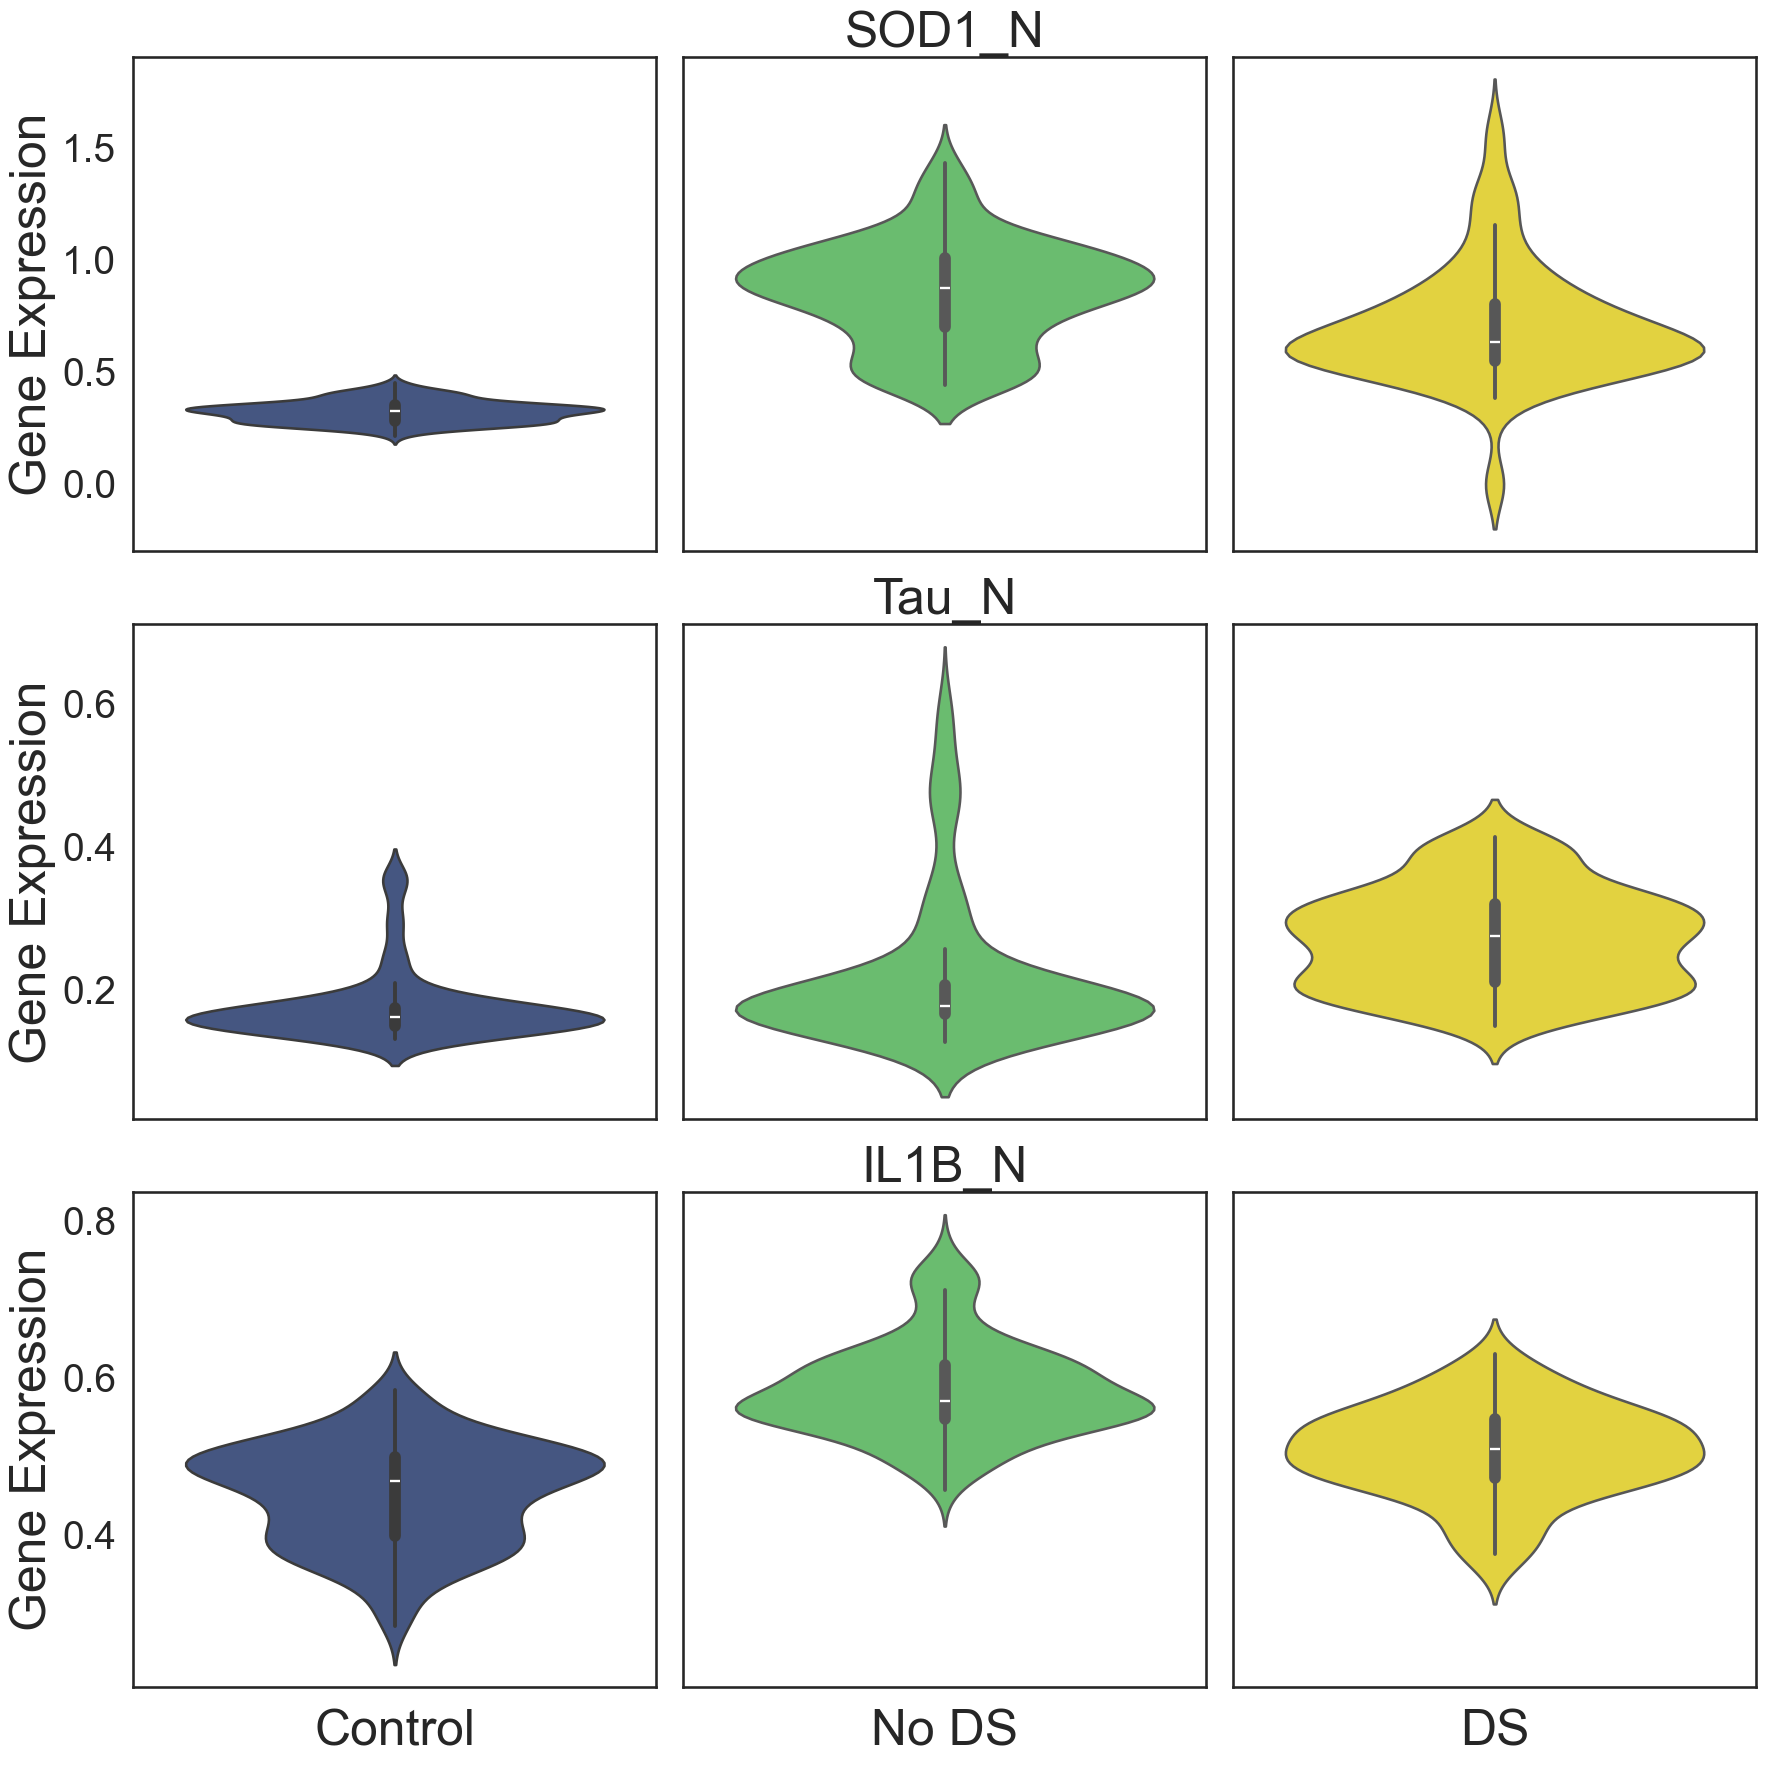

In [17]:

custom_palette = ["#440154", "#3B528B", "#21908C", "#5DC963", "#FDE725"]  

sns.set_theme(style="white", context="talk", palette="pastel")

group_colors = [custom_palette[1], custom_palette[3], custom_palette[4]]  

gene_indices = [cols_contrastive[1], cols_contrastive[4], cols_contrastive[6]]

fig, axes = plt.subplots(len(gene_indices), 3, figsize=(18, 6 * len(gene_indices)), sharex=False, sharey='row')

for i, gene_index in enumerate(gene_indices):
    gene_expression_foreground = target[:, gene_index]
    gene_expression_background = background[:, gene_index]
    
    data_foreground = pd.DataFrame({
        'Gene Expression': gene_expression_foreground,
        'Group': labels  
    })

    data_background = pd.DataFrame({
        'Gene Expression': gene_expression_background,
        'Group': ['Control'] * len(gene_expression_background)  
    })

    data_no_down_syndrome = data_foreground[data_foreground['Group'] == 0]
    data_down_syndrome = data_foreground[data_foreground['Group'] == 1]

    sns.violinplot(y='Gene Expression', data=data_background, ax=axes[i, 0], color=group_colors[0])
    if i == len(gene_indices) - 1:  
        axes[i, 0].set_xlabel('Control', fontsize=36)
    else:
        axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('Gene Expression', fontsize=36)  
    axes[i, 0].tick_params(axis='y', labelsize=28)

    # Plot No Down Syndrome group
    sns.violinplot(y='Gene Expression', data=data_no_down_syndrome, ax=axes[i, 1], color=group_colors[1])
    if i == len(gene_indices) - 1:  
        axes[i, 1].set_xlabel('No DS', fontsize=36)
    else:
        axes[i, 1].set_xlabel('')
    axes[i, 1].set_title(f"{foreground_gene_names[gene_index]}", fontsize=36)  
    axes[i, 1].tick_params(axis='y', labelsize=28)
    axes[i, 1].set_ylabel('')  

    sns.violinplot(y='Gene Expression', data=data_down_syndrome, ax=axes[i, 2], color=group_colors[2])
    if i == len(gene_indices) - 1:  
        axes[i, 2].set_xlabel('DS', fontsize=36)
    else:
        axes[i, 2].set_xlabel('')
    axes[i, 2].tick_params(axis='y', labelsize=28)
    axes[i, 2].set_ylabel('')  

plt.tight_layout()

# Save the figure in specified directory
os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/mouse protein')
#plt.savefig('mp_genes_combined.png', dpi=300, bbox_inches='tight')
os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work')
plt.savefig('ccur_mp.png', dpi=300, bbox_inches='tight')

plt.show()


In [12]:
labels = np.array(labels)
k =7
top_rows = 20
rows_foreground = deterministic_cur(X,k, top_rows)[4]

def calculate_proportion(rows, labels, nrow):
    """
    Calculate the proportion of 0 and 1 in the selected rows based on the labels array.
    """
    selected_labels = labels[rows]
    count_0 = np.sum(selected_labels == 0)
    count_1 = np.sum(selected_labels == 1)
    proportion_0 = count_0 / nrow
    proportion_1 = count_1 / nrow
    return count_0, count_1, proportion_0, proportion_1

count_0_contrastive, count_1_contrastive, prop_0_contrastive, prop_1_contrastive = calculate_proportion(rows_contrastive, labels, top_rows)
count_0_foreground, count_1_foreground, prop_0_foreground, prop_1_foreground = calculate_proportion(rows_foreground, labels, top_rows)

total_0 = np.sum(labels == 0)
total_1 = np.sum(labels == 1)
total = len(labels)
total_prop_0 = total_0 / total
total_prop_1 = total_1 / total

print("Proportion in rows_contrastive:")
print(f"Count 0: {count_0_contrastive}, Count 1: {count_1_contrastive}, Proportion 0: {prop_0_contrastive:.2f}, Proportion 1: {prop_1_contrastive:.2f}")

print("\nProportion in rows_foreground:")
print(f"Count 0: {count_0_foreground}, Count 1: {count_1_foreground}, Proportion 0: {prop_0_foreground:.2f}, Proportion 1: {prop_1_foreground:.2f}")

print("\nTotal counts and proportions across all labels:")
print(f"Total Count 0: {total_0}, Total Count 1: {total_1}, Total Proportion 0: {total_prop_0:.2f}, Total Proportion 1: {total_prop_1:.2f}")


Proportion in rows_contrastive:
Count 0: 12, Count 1: 8, Proportion 0: 0.60, Proportion 1: 0.40

Proportion in rows_foreground:
Count 0: 17, Count 1: 3, Proportion 0: 0.85, Proportion 1: 0.15

Total counts and proportions across all labels:
Total Count 0: 135, Total Count 1: 135, Total Proportion 0: 0.50, Total Proportion 1: 0.50


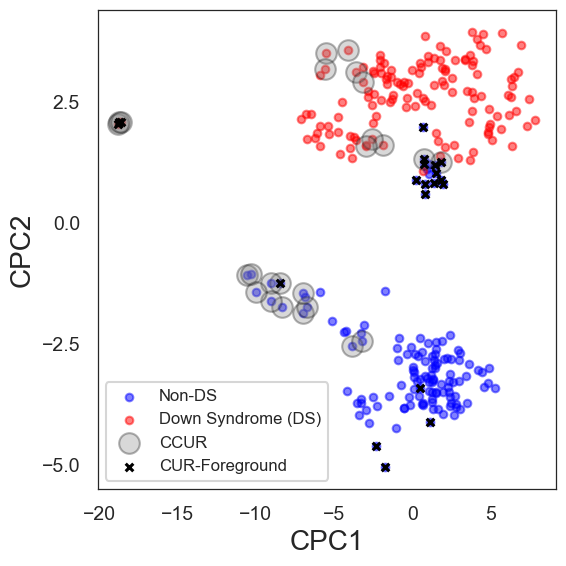

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

foreground_centered = (target - np.mean(target, axis=0))/ np.std(target,axis=0)
background_centered = (background - np.mean(background, axis=0)) / np.std(background,axis=0)

cov_foreground = np.cov(foreground_centered, rowvar=False)
cov_background = np.cov(background_centered, rowvar=False)
alpha = 2
cov_diff = cov_foreground - alpha * cov_background

eigenvalues, eigenvectors = np.linalg.eig(cov_diff)
idx = eigenvalues.argsort()[::-1]   
eigenvectors = eigenvectors[:,idx]
projected_data = foreground_centered @ eigenvectors[:,:2]

colors = ['blue', 'red']
legend_labels = ['Non-DS', 'Down Syndrome (DS)']

plt.figure(figsize=(6, 6))

non_ds_idx = (labels == 0)
plt.scatter(projected_data[non_ds_idx, 0], projected_data[non_ds_idx, 1],
            label=legend_labels[0],
            alpha=0.5, color=colors[0], s = 30)

ds_idx = (labels == 1)
plt.scatter(projected_data[ds_idx, 0], projected_data[ds_idx, 1],
            label=legend_labels[1],
            alpha=0.5, color=colors[1], s = 30)

plt.scatter(projected_data[rows_contrastive, 0], projected_data[rows_contrastive, 1],
            color='grey', edgecolor='black', s=220, alpha=0.3, marker='o', label='CCUR')

plt.scatter(projected_data[rows_foreground, 0], projected_data[rows_foreground, 1],
            color='black', marker='x', s=30, label='CUR-Foreground')

plt.title('', fontsize=20)
plt.xlabel('CPC1', fontsize=20)
plt.ylabel('CPC2', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12, loc='lower left')
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=4))  # limit to 4 y-ticks
plt.tight_layout()

for spine in plt.gca().spines.values():
    spine.set_linewidth(0.9)  # try 0.5–1.0 for thinner look

# Save
plt.savefig('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/mouse protein/ccur_rows_mp.png',dpi=300)
plt.show()


## non-iterative version ##

In [20]:
k = 7
c = 10
cols_contrastive = ccur(X,Y, k, c)[0]
foreground_gene_names[cols_contrastive]

array(['SOD1_N', 'AcetylH3K9_N', 'Tau_N', 'Bcatenin_N', 'MTOR_N',
       'pCFOS_N', 'P38_N', 'IL1B_N', 'SHH_N', 'ARC_N'], dtype=object)

In [21]:
cols_foreground = deterministic_cur(X, k, c)[3]
foreground_gene_names[cols_foreground]

array(['Bcatenin_N', 'pCAMKII_N', 'pELK_N', 'pPKCG_N', 'NR2A_N',
       'PSD95_N', 'ERK_N', 'AcetylH3K9_N', 'pCASP9_N', 'NR1_N'],
      dtype=object)

In [22]:
orig_indicies = deterministic_cur(np.concatenate((X,Y)), k, c)[3]
foreground_gene_names[orig_indicies]

array(['pCAMKII_N', 'Bcatenin_N', 'pPKCG_N', 'pELK_N', 'NR2A_N',
       'pPKCAB_N', 'ELK_N', 'PSD95_N', 'ERK_N', 'pERK_N'], dtype=object)

In [23]:
k = 7
top_rows = 25
rows_contrastive = deterministic_cur(X[:,cols_contrastive],k,top_rows)[4]
rows_foreground = deterministic_cur(X,k, top_rows)[4]

## Supplementary

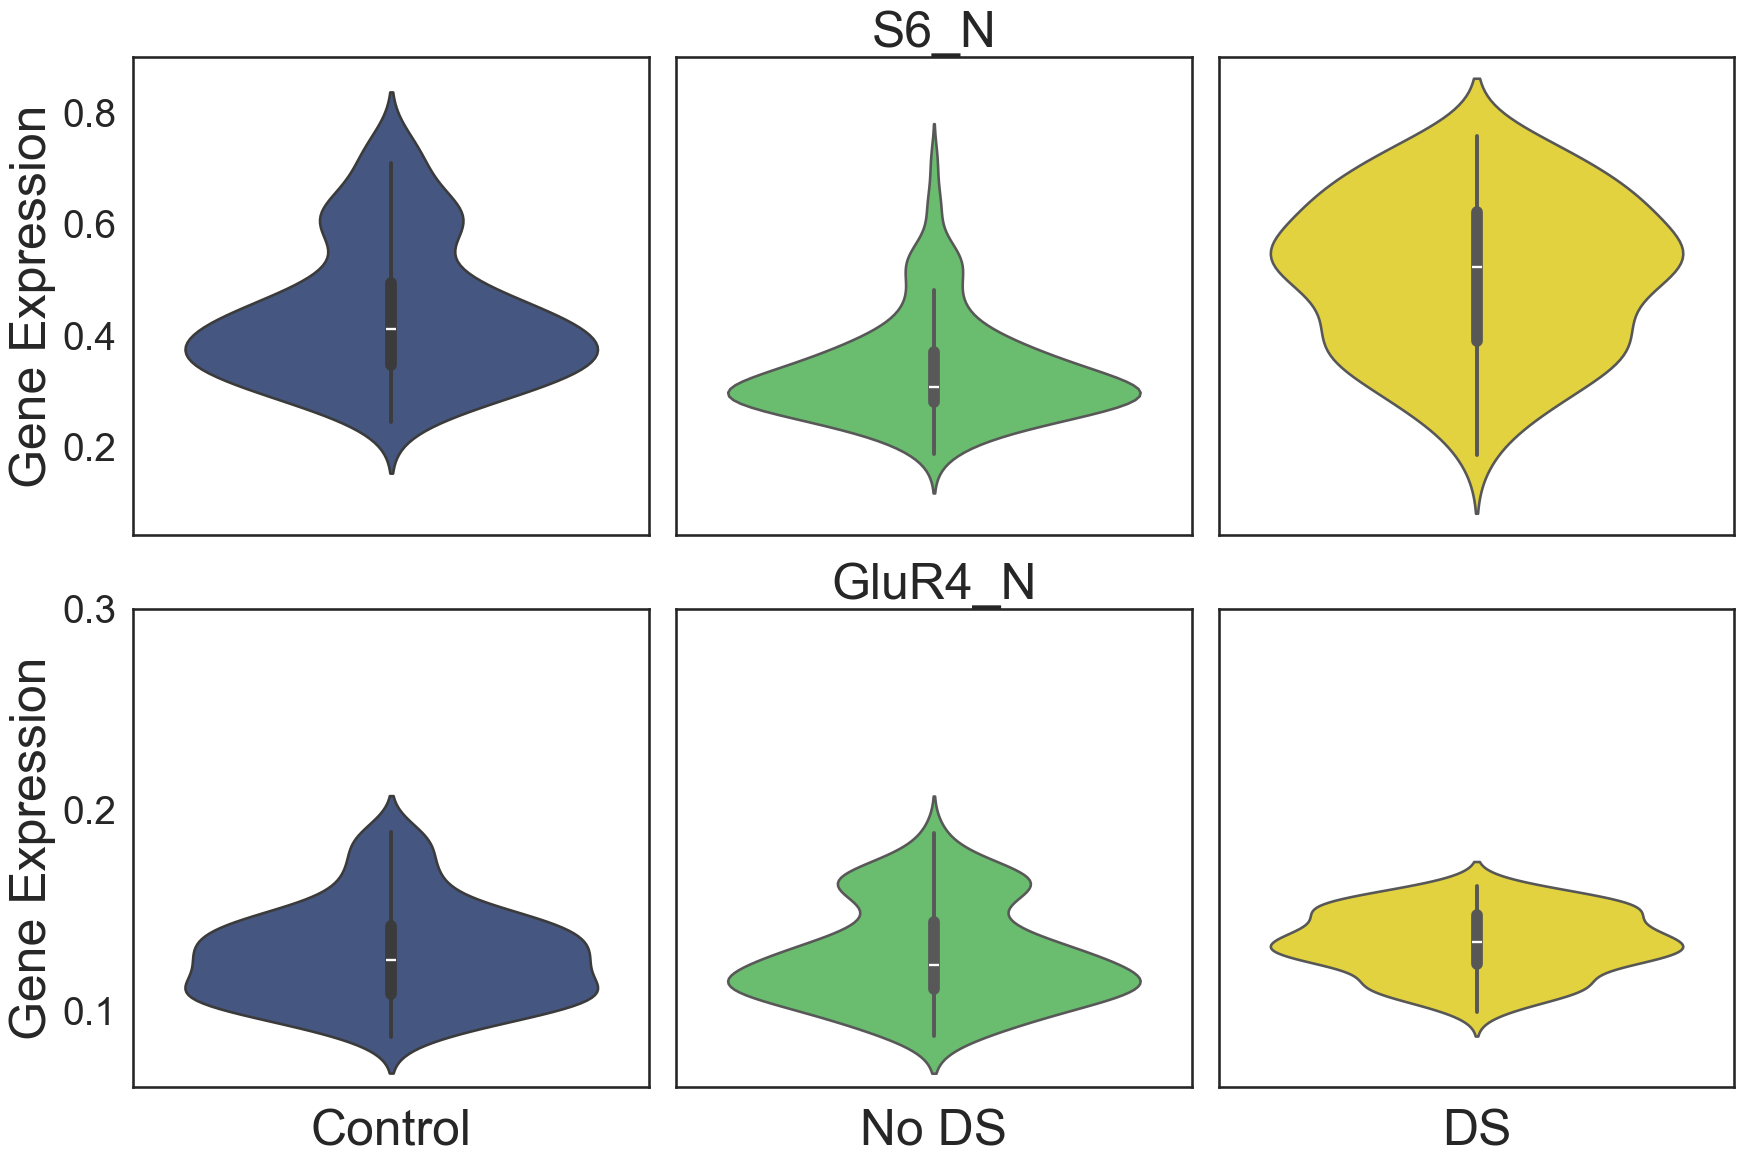

In [81]:
custom_palette = ["#440154", "#3B528B", "#21908C", "#5DC963", "#FDE725"]  

sns.set_theme(style="white", context="talk", palette="pastel")

group_colors = [custom_palette[1], custom_palette[3], custom_palette[4]] 

gene_indices = [S[2], S[5]]

fig, axes = plt.subplots(len(gene_indices), 3, figsize=(18, 6 * len(gene_indices)), sharex=False, sharey='row')

for i, gene_index in enumerate(gene_indices):
    gene_expression_foreground = target[:, gene_index]
    gene_expression_background = background[:, gene_index]
    
    data_foreground = pd.DataFrame({
        'Gene Expression': gene_expression_foreground,
        'Group': labels  
    })

    data_background = pd.DataFrame({
        'Gene Expression': gene_expression_background,
        'Group': ['Control'] * len(gene_expression_background) 
    })

    data_no_down_syndrome = data_foreground[data_foreground['Group'] == 0]
    data_down_syndrome = data_foreground[data_foreground['Group'] == 1]

    sns.violinplot(y='Gene Expression', data=data_background, ax=axes[i, 0], color=group_colors[0])
    if i == len(gene_indices) - 1:  
        axes[i, 0].set_xlabel('Control', fontsize=36)
    else:
        axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('Gene Expression', fontsize=36)  
    axes[i, 0].tick_params(axis='y', labelsize=28)

    sns.violinplot(y='Gene Expression', data=data_no_down_syndrome, ax=axes[i, 1], color=group_colors[1])
    if i == len(gene_indices) - 1:  
        axes[i, 1].set_xlabel('No DS', fontsize=36)
    else:
        axes[i, 1].set_xlabel('')
    axes[i, 1].set_title(f"{foreground_gene_names[gene_index]}", fontsize=36)  
    axes[i, 1].tick_params(axis='y', labelsize=28)
    axes[i, 1].set_ylabel('')  

    # Plot Down Syndrome group
    sns.violinplot(y='Gene Expression', data=data_down_syndrome, ax=axes[i, 2], color=group_colors[2])
    if i == len(gene_indices) - 1:  
        axes[i, 2].set_xlabel('DS', fontsize=36)
    else:
        axes[i, 2].set_xlabel('')
    axes[i, 2].tick_params(axis='y', labelsize=28)
    axes[i, 2].set_ylabel('') 

plt.tight_layout()

if len(gene_indices) > 1:  
    for j in range(3): 
        axes[1, j].set_yticks([0.1, 0.2, 0.3])  

# Save the figure
os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/mouse protein')
plt.savefig('mp_ccur_suppl.png', dpi=300, bbox_inches='tight')

plt.show()


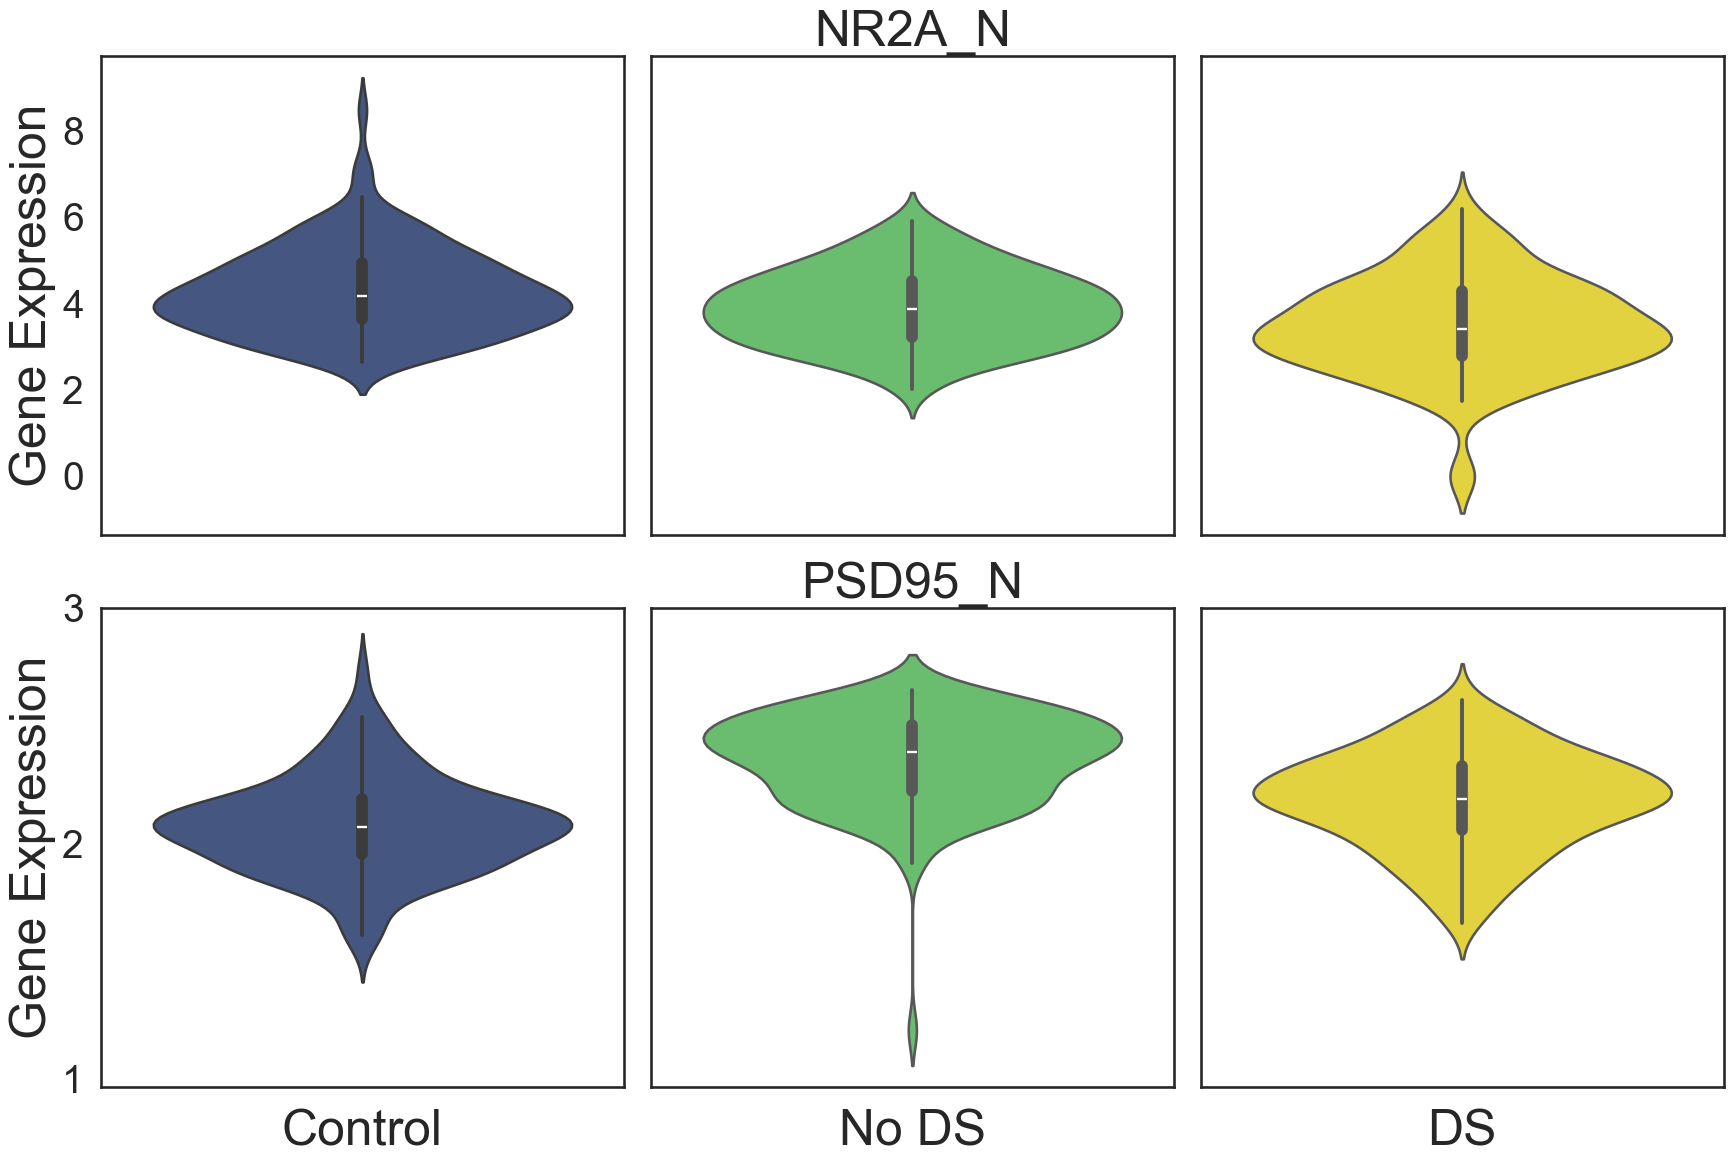

In [77]:
custom_palette = ["#440154", "#3B528B", "#21908C", "#5DC963", "#FDE725"]  

sns.set_theme(style="white", context="talk", palette="pastel")

group_colors = [custom_palette[1], custom_palette[3], custom_palette[4]]  

gene_indices = [cols_foreground[4], cols_foreground[5]]

fig, axes = plt.subplots(len(gene_indices), 3, figsize=(18, 6 * len(gene_indices)), sharex=False, sharey='row')

for i, gene_index in enumerate(gene_indices):
    gene_expression_foreground = target[:, gene_index]
    gene_expression_background = background[:, gene_index]
    
    data_foreground = pd.DataFrame({
        'Gene Expression': gene_expression_foreground,
        'Group': labels  
    })

    data_background = pd.DataFrame({
        'Gene Expression': gene_expression_background,
        'Group': ['Control'] * len(gene_expression_background)  
    })

    data_no_down_syndrome = data_foreground[data_foreground['Group'] == 0]
    data_down_syndrome = data_foreground[data_foreground['Group'] == 1]

    sns.violinplot(y='Gene Expression', data=data_background, ax=axes[i, 0], color=group_colors[0])
    if i == len(gene_indices) - 1:  
        axes[i, 0].set_xlabel('Control', fontsize=36)
    else:
        axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('Gene Expression', fontsize=36)  
    axes[i, 0].tick_params(axis='y', labelsize=28)

    sns.violinplot(y='Gene Expression', data=data_no_down_syndrome, ax=axes[i, 1], color=group_colors[1])
    if i == len(gene_indices) - 1: 
        axes[i, 1].set_xlabel('No DS', fontsize=36)
    else:
        axes[i, 1].set_xlabel('')
    axes[i, 1].set_title(f"{foreground_gene_names[gene_index]}", fontsize=36)  
    axes[i, 1].tick_params(axis='y', labelsize=28)
    axes[i, 1].set_ylabel('')  

    sns.violinplot(y='Gene Expression', data=data_down_syndrome, ax=axes[i, 2], color=group_colors[2])
    if i == len(gene_indices) - 1:  
        axes[i, 2].set_xlabel('DS', fontsize=36)
    else:
        axes[i, 2].set_xlabel('')
    axes[i, 2].tick_params(axis='y', labelsize=28)
    axes[i, 2].set_ylabel('')  

plt.tight_layout()

if len(gene_indices) > 1:  
    for j in range(3):  
        axes[1, j].set_yticks([1,2,3])  

os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/mouse protein')
#plt.savefig('mp_cur_suppl.png', dpi=300, bbox_inches='tight')

plt.show()


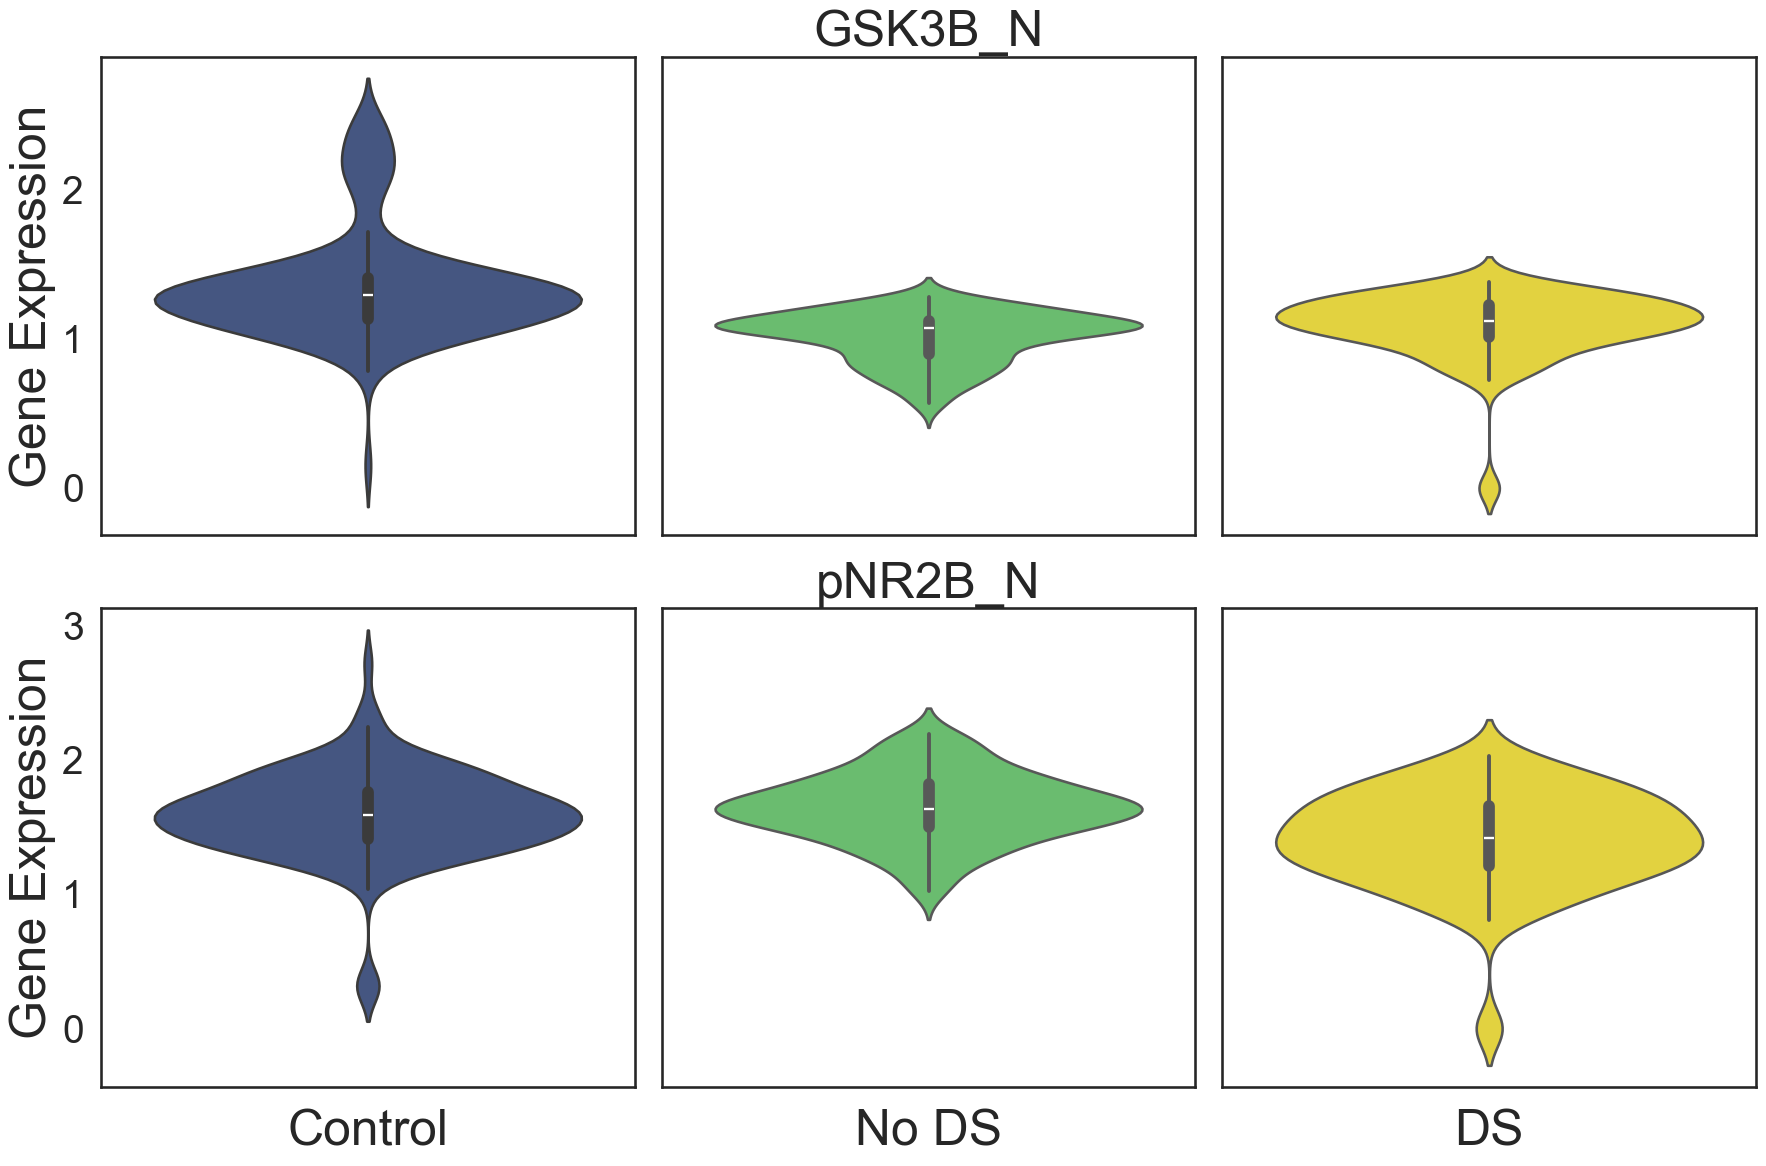

In [51]:
custom_palette = ["#440154", "#3B528B", "#21908C", "#5DC963", "#FDE725"]  

sns.set_theme(style="white", context="talk", palette="pastel")

group_colors = [custom_palette[1], custom_palette[3], custom_palette[4]]

gene_indices = [cpca_indices[1], cpca_indices[3]]

fig, axes = plt.subplots(len(gene_indices), 3, figsize=(18, 6 * len(gene_indices)), sharex=False, sharey='row')

for i, gene_index in enumerate(gene_indices):
    gene_expression_foreground = target[:, gene_index]
    gene_expression_background = background[:, gene_index]
    
    data_foreground = pd.DataFrame({
        'Gene Expression': gene_expression_foreground,
        'Group': labels  
    })

    data_background = pd.DataFrame({
        'Gene Expression': gene_expression_background,
        'Group': ['Control'] * len(gene_expression_background)  
    })

    data_no_down_syndrome = data_foreground[data_foreground['Group'] == 0]
    data_down_syndrome = data_foreground[data_foreground['Group'] == 1]

    sns.violinplot(y='Gene Expression', data=data_background, ax=axes[i, 0], color=group_colors[0])
    if i == len(gene_indices) - 1:  
        axes[i, 0].set_xlabel('Control', fontsize=36)
    else:
        axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('Gene Expression', fontsize=36)  
    axes[i, 0].tick_params(axis='y', labelsize=28)

    sns.violinplot(y='Gene Expression', data=data_no_down_syndrome, ax=axes[i, 1], color=group_colors[1])
    if i == len(gene_indices) - 1: 
        axes[i, 1].set_xlabel('No DS', fontsize=36)
    else:
        axes[i, 1].set_xlabel('')
    axes[i, 1].set_title(f"{foreground_gene_names[gene_index]}", fontsize=36)  
    axes[i, 1].tick_params(axis='y', labelsize=28)
    axes[i, 1].set_ylabel('') 

    sns.violinplot(y='Gene Expression', data=data_down_syndrome, ax=axes[i, 2], color=group_colors[2])
    if i == len(gene_indices) - 1:  
        axes[i, 2].set_xlabel('DS', fontsize=36)
    else:
        axes[i, 2].set_xlabel('')
    axes[i, 2].tick_params(axis='y', labelsize=28)
    axes[i, 2].set_ylabel('') 

plt.tight_layout()


os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/mouse protein')
#plt.savefig('mp_cpca_suppl.png', dpi=300, bbox_inches='tight')

plt.show()


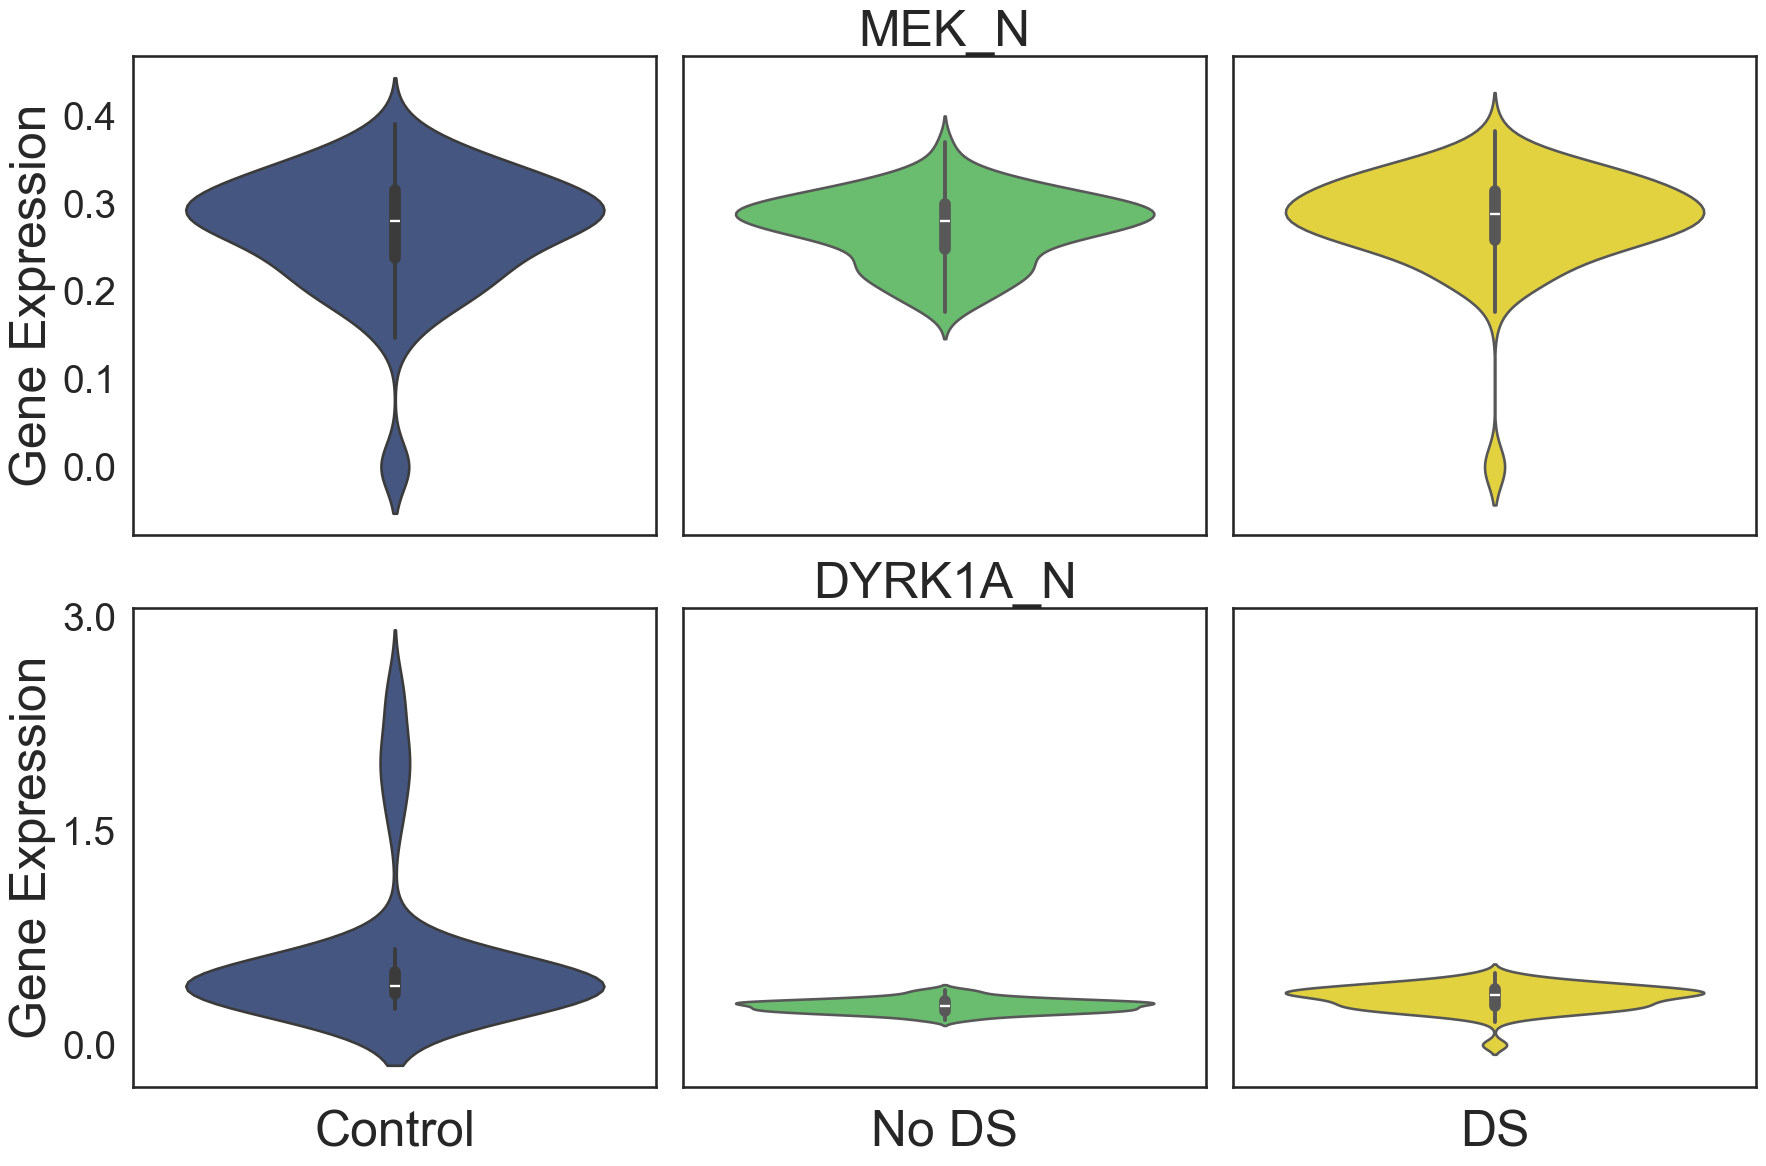

In [52]:
custom_palette = ["#440154", "#3B528B", "#21908C", "#5DC963", "#FDE725"]  

sns.set_theme(style="white", context="talk", palette="pastel")

group_colors = [custom_palette[1], custom_palette[3], custom_palette[4]]  

#ccur paper
gene_indices = [data_pd.columns.get_loc("MEK_N") - 1, data_pd.columns.get_loc("DYRK1A_N") - 1]


fig, axes = plt.subplots(len(gene_indices), 3, figsize=(18, 6 * len(gene_indices)), sharex=False, sharey='row')

for i, gene_index in enumerate(gene_indices):
    gene_expression_foreground = target[:, gene_index]
    gene_expression_background = background[:, gene_index]
    
    data_foreground = pd.DataFrame({
        'Gene Expression': gene_expression_foreground,
        'Group': labels  
    })

    data_background = pd.DataFrame({
        'Gene Expression': gene_expression_background,
        'Group': ['Control'] * len(gene_expression_background)  
    })

    data_no_down_syndrome = data_foreground[data_foreground['Group'] == 0]
    data_down_syndrome = data_foreground[data_foreground['Group'] == 1]

    sns.violinplot(y='Gene Expression', data=data_background, ax=axes[i, 0], color=group_colors[0])
    if i == len(gene_indices) - 1:  
        axes[i, 0].set_xlabel('Control', fontsize=36)
    else:
        axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('Gene Expression', fontsize=36)  
    axes[i, 0].tick_params(axis='y', labelsize=28)

    sns.violinplot(y='Gene Expression', data=data_no_down_syndrome, ax=axes[i, 1], color=group_colors[1])
    if i == len(gene_indices) - 1:  
        axes[i, 1].set_xlabel('No DS', fontsize=36)
    else:
        axes[i, 1].set_xlabel('')
    axes[i, 1].set_title(f"{foreground_gene_names[gene_index]}", fontsize=36)  
    axes[i, 1].tick_params(axis='y', labelsize=28)
    axes[i, 1].set_ylabel('')  

    sns.violinplot(y='Gene Expression', data=data_down_syndrome, ax=axes[i, 2], color=group_colors[2])
    if i == len(gene_indices) - 1:  
        axes[i, 2].set_xlabel('DS', fontsize=36)
    else:
        axes[i, 2].set_xlabel('')
    axes[i, 2].tick_params(axis='y', labelsize=28)
    axes[i, 2].set_ylabel('') 

plt.tight_layout()

if len(gene_indices) > 1:
    for j in range(3):
        axes[1, j].set_yticks([0, 1.5, 3.0])


os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/mouse protein')
#plt.savefig('mp_cfs_suppl.png', dpi=300, bbox_inches='tight')
#plt.savefig('mp_cfs_suppl.png', dpi=300, bbox_inches='tight')

plt.show()
